### Aim of this notebook is to predict the forward return of stocks in the S&P 500 Index. To start with, we will simply predict the sign of the return (Positive, Negative, Zero) but can later move on to regression.

# Imports

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
import seaborn as sns
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Get data

In [2]:
# Get raw data
companies = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_companies.csv")
index = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_index.csv", parse_dates=['Date'])
stocks = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_stocks.csv", parse_dates=['Date'])
macro = pd.read_csv("/kaggle/input/macroeconomic-factors-affecting-us-housing-prices/DATA.csv", parse_dates=['DATE'])

In [3]:
companies.head(10)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,406.32,3019136303104,1.261340e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.063284
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,169.30,2614313615360,1.301090e+11,0.021,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.054799
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,877.35,2193374969856,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.045975
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,171.95,2150045581312,1.090070e+11,0.154,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.045067
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,173.69,2144984760320,1.090070e+11,0.154,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.044961
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,179.62,1868532940800,8.551500e+10,0.139,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.039166
6,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,443.29,1124418322432,6.882200e+10,0.273,Menlo Park,CA,United States,69329.0,"Meta Platforms, Inc. engages in the developmen...",0.023569
7,NYQ,BRK-B,Berkshire Hathaway Inc. New,Berkshire Hathaway Inc.,Financial Services,Insurance - Diversified,402.10,869480988672,1.356820e+11,0.196,Omaha,NE,United States,396500.0,"Berkshire Hathaway Inc., through its subsidiar...",0.018225
8,NYQ,LLY,Eli Lilly and Company,Eli Lilly and Company,Healthcare,Drug Manufacturers - General,733.51,697396363264,1.231460e+10,0.281,Indianapolis,IN,United States,43000.0,"Eli Lilly and Company discovers, develops, and...",0.014618
9,NMS,AVGO,Broadcom Inc.,Broadcom Inc.,Technology,Semiconductors,1344.07,622870200320,2.040400e+10,0.164,Palo Alto,CA,United States,20000.0,"Broadcom Inc. designs, develops, and supplies ...",0.013056


In [4]:
index.head(10)

,Date,S&P500
0,2014-04-28,1869.43
1,2014-04-29,1878.33
2,2014-04-30,1883.95
3,2014-05-01,1883.68
4,2014-05-02,1881.14
5,2014-05-05,1884.66
6,2014-05-06,1867.72
7,2014-05-07,1878.21
8,2014-05-08,1875.63
9,2014-05-09,1878.48


In [5]:
stocks.head(10)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,40.835045,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,40.579269,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,41.154747,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,41.184265,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,41.474472,70.501671,70.501671,69.648827,69.974915,4073337.0
5,2010-01-11,MMM,41.307232,70.217392,70.735786,69.740807,70.551842,3500812.0
6,2010-01-12,MMM,41.341671,70.275917,70.384613,69.648827,69.882942,3626033.0
7,2010-01-13,MMM,41.208862,70.050163,70.326088,69.565216,70.326088,3709992.0
8,2010-01-14,MMM,41.071136,69.816055,70.175583,69.749161,70.016724,3150384.0
9,2010-01-15,MMM,41.007195,69.707359,70.309364,69.289299,69.832779,4730180.0


In [6]:
macro.head(10)

,DATE,UNRATE(%),CONSUMER CONF INDEX,PPI-CONST MAT.,CPIALLITEMS,INFLATION(%),MORTGAGE INT. MONTHLY AVG(%),MED HOUSEHOLD INCOME,CORP. BOND YIELD(%),MONTHLY HOME SUPPLY,% SHARE OF WORKING POPULATION,GDP PER CAPITA,QUARTERLY REAL GDP,QUARTERLY GDP GROWTH RATE (%),CSUSHPISA
0,2022-01-05,3.6,106.4,352.857,123.322800,8.581511,5.2300,NaN,4.13,8.4,NaN,74737,19699.465,-0.144227,120.724
1,2022-01-04,3.6,107.3,343.730,121.978170,8.258629,4.9825,NaN,3.76,8.4,NaN,74737,19699.465,-0.144227,121.813
2,2022-01-03,3.6,107.2,345.852,121.301004,8.542456,4.1720,NaN,3.43,7.0,NaN,73289,19727.918,-0.395692,122.888
3,2022-01-02,3.8,110.5,343.583,119.702806,7.871064,3.7625,NaN,3.25,6.0,NaN,73289,19727.918,-0.395692,123.831
4,2022-01-01,4.0,113.8,345.742,118.619339,7.479872,3.4450,NaN,2.93,5.7,NaN,73289,19727.918,-0.395692,124.780
5,2021-01-12,3.9,115.8,335.032,117.629537,7.036403,3.0980,NaN,2.65,5.6,64.924129,72171,19806.290,1.680778,125.734
6,2021-01-11,4.2,109.5,328.940,117.269225,6.809003,3.0675,NaN,2.62,6.2,64.924129,72171,19806.290,1.680778,126.669
7,2021-01-10,4.6,113.8,322.120,116.695849,6.221869,3.0675,NaN,2.68,6.9,64.924129,72171,19806.290,1.680778,127.622
8,2021-01-09,4.7,109.3,317.136,115.734314,5.390349,2.9000,NaN,2.53,6.1,64.924129,69824,19478.893,0.570948,128.461
9,2021-01-08,5.2,113.8,313.083,115.420835,5.251272,2.8425,NaN,2.55,6.5,64.924129,69824,19478.893,0.570948,129.355


In [7]:
########################################################
# Join into one wide table which will be our raw dataset
########################################################
# Join index table onto stocks table
df = stocks.merge(
    right=index,
    how='left',
    left_on='Date',
    right_on='Date'
)

# Join companies table onto stocks and index table, dropping some unecessary columns from companies table
df = df.merge(
    right=companies[['Symbol', 'Sector',]],
    how='left',
    left_on='Symbol',
    right_on='Symbol'
)

# Since macro is month start data, get YYYYMM to use as a column to join on
macro['YYYYMM'] = macro['DATE'].dt.strftime('%Y%d%m').str[:6]
df['YYYYMM'] = df['Date'].dt.strftime('%Y%m%d').str[:6]

# Join macro table onto dataframe
df = df.merge(
    right=macro,
    how='left',
    left_on='YYYYMM',
    right_on='YYYYMM'
)

###################################################################
# Trim data for start and end dates and drop columns used for joins
###################################################################

# Drop dates older than 10 years ago (S&P only provides data with 10 year rolling history)
ten_years_ago = datetime.now() - timedelta(days=365.25*10)
df = df[df['Date'] >= ten_years_ago].reset_index(drop=True)

# Drop dates after 1st May 2022 (this is when the macro data ends)
df = df[df['Date'] <= pd.to_datetime("2022-05-01")]

# Drop columns used to join and other unecessary columns and rename columns
to_drop = ['DATE', 'YYYYMM', 'MONTHLY HOME SUPPLY', '% SHARE OF WORKING POPULATION', 'PPI-CONST MAT.', 'MED HOUSEHOLD INCOME']
df.drop(to_drop, axis=1, inplace=True)
df.rename(
    mapper={
        'INFLATION(%)': 'Inflation (%)',
        'MORTGAGE INT. MONTHLY AVG(%)': 'Monthly Average Mortgage Rate (%)',
        'CORP. BOND YIELD(%)': 'Corporate Bond Yield',
        'GDP PER CAPITA': 'GDP Per Capita',
        'QUARTERLY REAL GDP': 'Quarterly Real GDP',
        'QUARTERLY GDP GROWTH RATE (%)': 'Quarterly GDP Growth Rate (%)',
        'CSUSHPISA': 'Home Price Index',
        'CPIALLITEMS': 'CPI All Items',
        'CONSUMER CONF INDEX': 'Consumer Confidence Index',
        'UNRATE(%)': 'Unemployment Rate (%)'
    },
    axis=1,
    inplace=True
)

# Order by date for ease
df.sort_values(
    by='Date',
    inplace=True,
    ignore_index=True
)

# Reset index
df = df.reset_index(drop=True)

In [8]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Sector,Unemployment Rate (%),Consumer Confidence Index,CPI All Items,Inflation (%),Monthly Average Mortgage Rate (%),Corporate Bond Yield,GDP Per Capita,Quarterly Real GDP,Quarterly GDP Growth Rate (%),Home Price Index
0,2014-04-29,MMM,76.839798,115.008362,115.301003,114.180603,115.275917,2177796.0,1878.33,Industrials,6.2,82.3,100.023205,1.952858,4.3375,4.24,54703.0,16868.109,1.284129,145.717
1,2014-04-29,MSI,53.227810,63.430000,63.669998,62.709999,63.000000,1152700.0,1878.33,Technology,6.2,82.3,100.023205,1.952858,4.3375,4.24,54703.0,16868.109,1.284129,145.717
2,2014-04-29,ETR,52.268883,72.889999,73.709999,72.629997,73.129997,2505900.0,1878.33,Utilities,6.2,82.3,100.023205,1.952858,4.3375,4.24,54703.0,16868.109,1.284129,145.717
3,2014-04-29,YUM,45.979881,55.341480,56.002876,55.255211,55.938175,4141703.0,1878.33,Consumer Cyclical,6.2,82.3,100.023205,1.952858,4.3375,4.24,54703.0,16868.109,1.284129,145.717
4,2014-04-29,ACN,67.207680,79.680000,79.769997,78.839996,79.029999,2315900.0,1878.33,Technology,6.2,82.3,100.023205,1.952858,4.3375,4.24,54703.0,16868.109,1.284129,145.717


In [9]:
df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'S&P500', 'Sector', 'Unemployment Rate (%)',
       'Consumer Confidence Index', 'CPI All Items', 'Inflation (%)',
       'Monthly Average Mortgage Rate (%)', 'Corporate Bond Yield',
       'GDP Per Capita', 'Quarterly Real GDP', 'Quarterly GDP Growth Rate (%)',
       'Home Price Index'],
      dtype='object')

# EDA

## Column info

In [10]:
# Column types and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014551 entries, 0 to 1014550
Data columns (total 20 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   Date                               1014551 non-null  datetime64[ns]
 1   Symbol                             1014551 non-null  object        
 2   Adj Close                          983122 non-null   float64       
 3   Close                              983122 non-null   float64       
 4   High                               983122 non-null   float64       
 5   Low                                983122 non-null   float64       
 6   Open                               983122 non-null   float64       
 7   Volume                             983122 non-null   float64       
 8   S&P500                             1014551 non-null  float64       
 9   Sector                             1012534 non-null  object        
 10  Unempl

In [11]:
# Distribution of columns
print(df.describe())

                                Date      Adj Close          Close  \
count                        1014551  983122.000000  983122.000000   
mean   2018-04-29 01:14:14.933068800     105.169544     112.359587   
min              2014-04-29 00:00:00       0.700000       0.700000   
25%              2016-04-28 00:00:00      37.681505      43.180000   
50%              2018-04-30 00:00:00      64.691048      73.040001   
75%              2020-04-30 00:00:00     115.271280     125.089996   
max              2022-04-29 00:00:00    5959.330078    5959.330078   
std                              NaN     190.980903     191.091255   

                High            Low           Open        Volume  \
count  983122.000000  983122.000000  983122.000000  9.831220e+05   
mean      113.609217     111.063630     112.353436  5.193557e+06   
min         0.710000       0.650000       0.700000  0.000000e+00   
25%        43.660000      42.669998      43.169998  9.618000e+05   
50%        73.779999      72.

## Survivorship bias?

In [12]:
# Check if there is any difference in constituents over time
unique_constituents = stocks.groupby('Date')['Symbol'].unique().reset_index()['Symbol']
first_constituents = unique_constituents[0]
difference = False
for u in unique_constituents:
    if len(u) != len(first_constituents):
        print("Length mismatch")
        difference = True
        break
    elif not all(f == x for f, x in zip(first_constituents, u)):
        print("Constituent mismatch")
        difference = True
        break
print(f"Constituents change over time? {difference}")

Constituents change over time? False


## Plots

<Axes: title={'center': 'Value of S&P 500'}, xlabel='Date'>

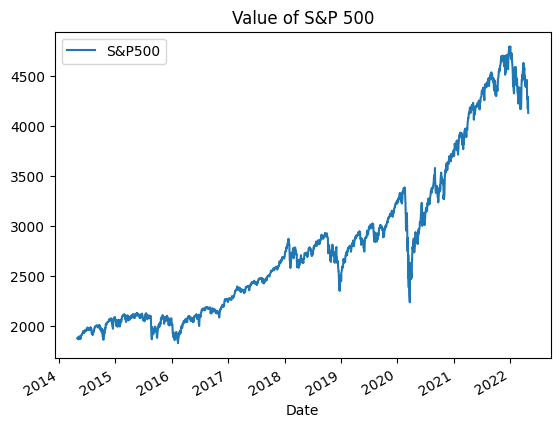

In [13]:
# Plot S&P 500 index value over time
df.plot(x='Date', y='S&P500', title='Value of S&P 500')

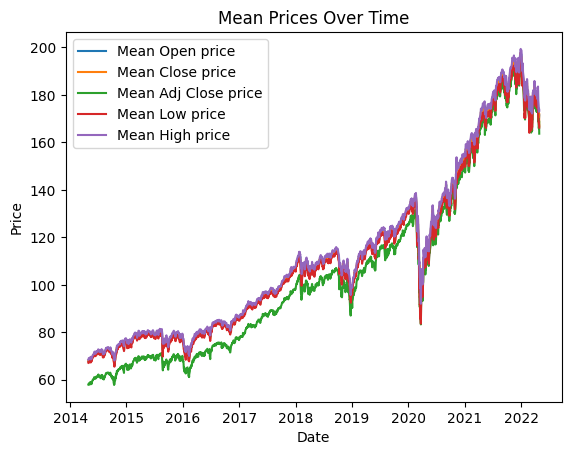

In [14]:
# Plot mean prices over time
mean_open = df.pivot(index='Date', columns='Symbol', values=['Open']).mean(axis=1)
mean_close = df.pivot(index='Date', columns='Symbol', values=['Close']).mean(axis=1)
mean_adj_close = df.pivot(index='Date', columns='Symbol', values=['Adj Close']).mean(axis=1)
mean_low = df.pivot(index='Date', columns='Symbol', values=['Low']).mean(axis=1)
mean_high = df.pivot(index='Date', columns='Symbol', values=['High']).mean(axis=1)
plt.plot(mean_open, label='Mean Open price')
plt.plot(mean_close, label='Mean Close price')
plt.plot(mean_adj_close, label='Mean Adj Close price')
plt.plot(mean_low, label='Mean Low price')
plt.plot(mean_high, label='Mean High price')
plt.title('Mean Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Axes: title={'center': 'Mean Trading Volume of S&P 500 Constituents Over Time'}, xlabel='Date'>

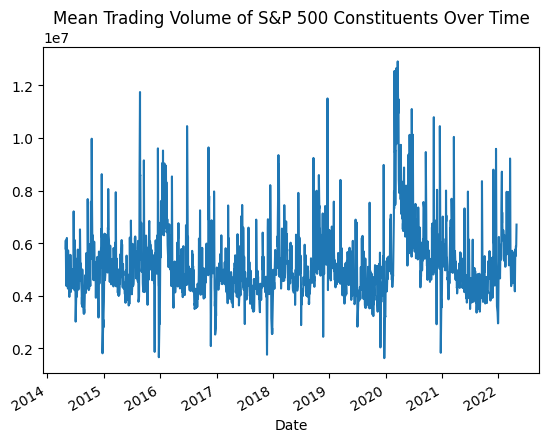

In [15]:
# Plot median trading volume over time
df.pivot(index='Date', columns='Symbol', values='Volume').mean(axis=1).plot(title='Mean Trading Volume of S&P 500 Constituents Over Time')

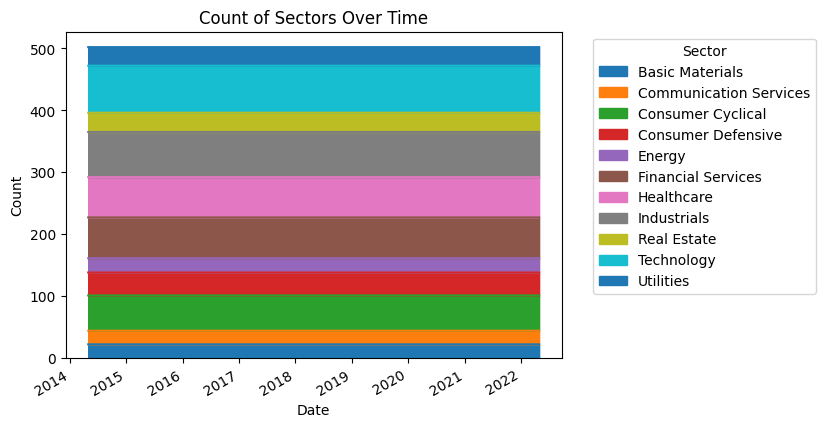

In [16]:
# Plot current sector distribution
sector_counts = df.groupby('Date')['Sector'].value_counts().unstack(fill_value=0)
sector_counts.plot(kind='area')
plt.title('Count of Sectors Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

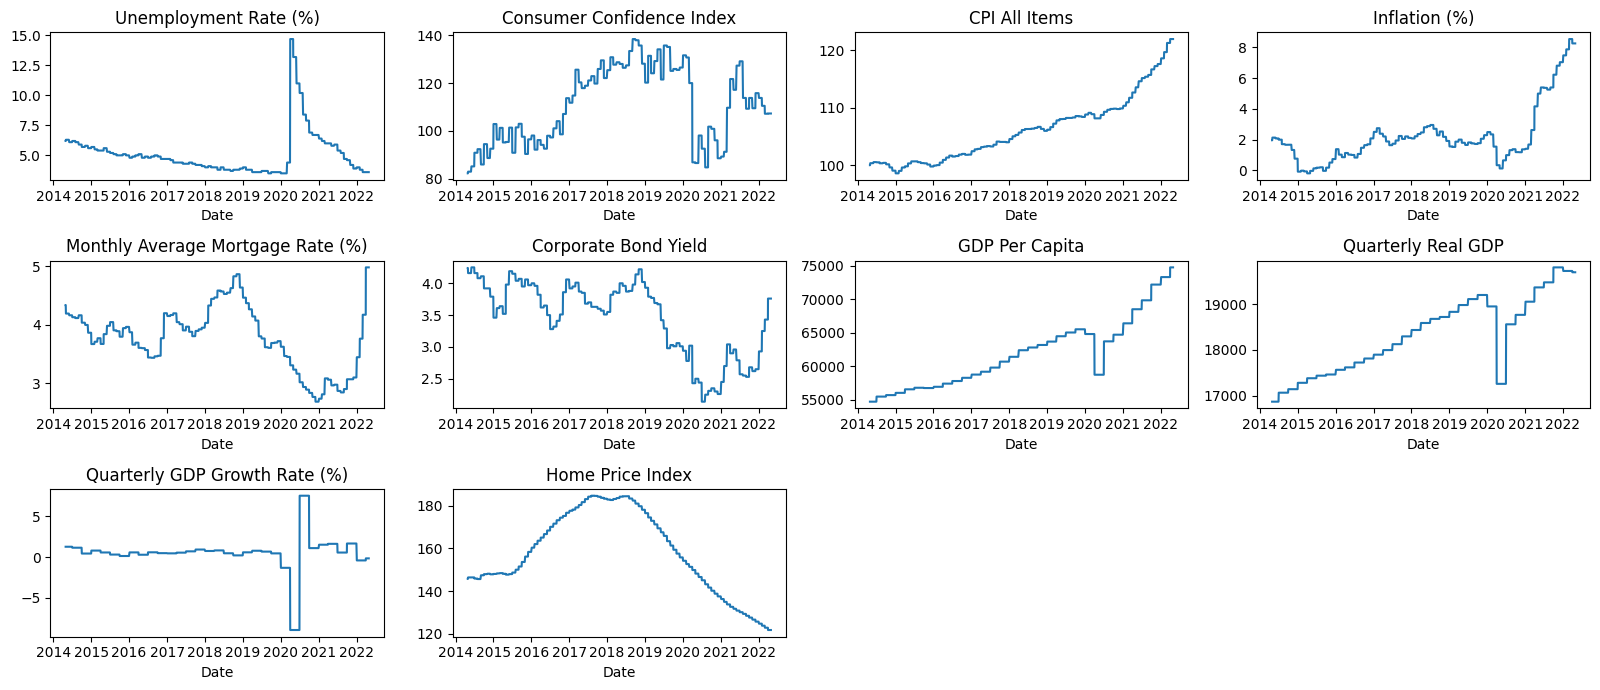

In [17]:
###########################
# Plot macro indicators
###########################

# Cols to plot
macro_cols = ['Unemployment Rate (%)',
       'Consumer Confidence Index', 'CPI All Items', 'Inflation (%)',
       'Monthly Average Mortgage Rate (%)',
       'Corporate Bond Yield', 'GDP Per Capita', 'Quarterly Real GDP',
       'Quarterly GDP Growth Rate (%)', 'Home Price Index']

# Calculate the number of rows and columns for the grid layout
num_plots = len(macro_cols)
num_rows = (num_plots - 1) // 4 + 1  # Number of rows (4 plots per row)
num_cols = min(num_plots, 4)  # Number of columns (maximum 4 plots per row)

# Create the subplots with the desired grid layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 7))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(macro_cols):
    row = i // num_cols 
    col = i % num_cols

    # Select the appropriate subplot
    if num_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]
    
    # Plot
    ax.plot(df['Date'], df[column])
    ax.set_title(column)
    ax.set_xlabel('Date') 

# Remove any empty subplots
if num_plots < num_rows * num_cols:
    if num_rows > 1:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i // num_cols, i % num_cols])
    else:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes[i])

# Adjust spacing
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
plt.tight_layout()  # Adjust the spacing between subplots

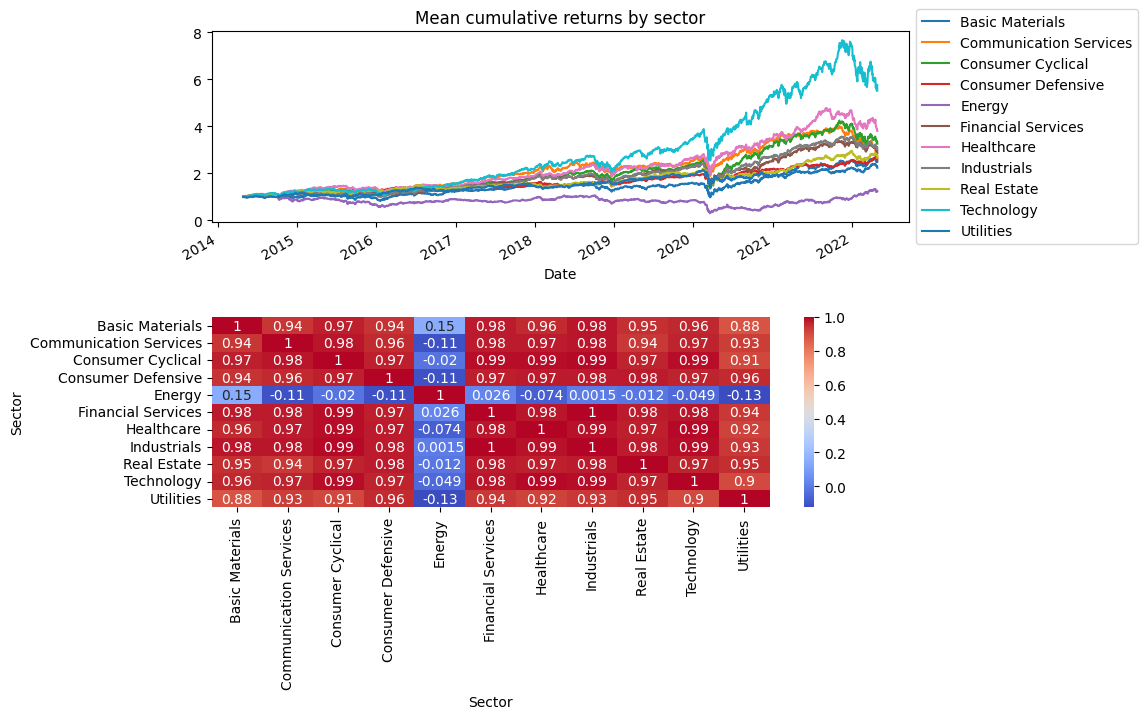

In [18]:
#############################################################################
# Returns in each sector and their correlations
#############################################################################

# Calulate cumulative returns using 1-day forward returns
sector_returns_df = df[['Date', 'Symbol', 'Sector', 'Adj Close']].copy()
sector_returns_df['1-Day Forward Adj Close'] = sector_returns_df.groupby('Symbol')['Adj Close'].shift(-1)
sector_returns_df['1-Day Forward Return'] = (sector_returns_df['1-Day Forward Adj Close'] - sector_returns_df['Adj Close']) / sector_returns_df['Adj Close']
sector_returns_df.drop('1-Day Forward Adj Close', axis=1, inplace=True)
sector_returns_df['Cumulative Return'] = sector_returns_df.groupby('Symbol')['1-Day Forward Return'].transform(lambda x: (1 + x).cumprod())

# Calculate mean cumulative return by sector at each date
sector_returns_df = sector_returns_df.pivot_table(index='Date', columns='Sector', values='Cumulative Return', aggfunc='mean')

# Calculate and plot sector returns and correlation matrix
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7))
sector_returns_df.plot(ax=ax1, title='Mean cumulative returns by sector')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sector_correlations = sector_returns_df.corr()
sns.heatmap(sector_correlations, annot=True, cmap='coolwarm', ax=ax2)
plt.subplots_adjust(hspace=0.5)
plt.show()

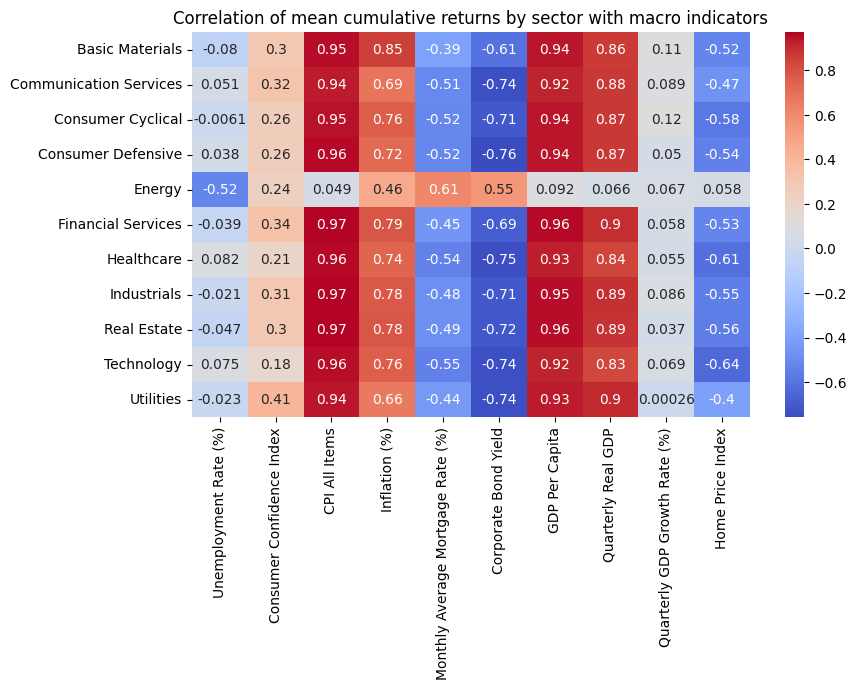

In [19]:
###############################################################
# Correlation of sector level returns with each macro indicator
###############################################################
# Combine macro data with sector returns data
sector_returns_with_macro = pd.merge(
    left=sector_returns_df,
    right=df[['Date'] + macro_cols],
    how='left',
    on='Date'
)

# Calculate correlation matrix of sector-level returns with macro indicator
macro_sector_correlation = sector_returns_with_macro.drop('Date', axis=1).corr()
unique_sectors = list(df['Sector'].dropna().unique())
macro_sector_correlation.drop(unique_sectors, axis=1, inplace=True)
macro_sector_correlation.drop(macro_cols, axis=0, inplace=True)

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(9,5)) 
sns.heatmap(macro_sector_correlation, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation of mean cumulative returns by sector with macro indicators")
plt.show()


# TODO 
--To calculate correlations of sector returns with macro factors, need to do monthly returns. Use daily returns between 1st and 1st of next month to calculate monthly returns. Then drop rows so we just have start of month data with monthly returns. Then do the correlation to macro factors.

-- Generate a shit load of featues

# Data cleaning

The first thing to note is that the dataset is all current S&P 500 constituents historically, rather than consituents at the time, so there is some inherent survivorship bias. Also, it turns out that we get data for a ticker when the stock goes public - which is before it enters the index. Before the ticker goes public, we have no pricing data. We can't backfill as this would cause look-ahead bias and doesn't make sense anyway since those stocks wouldn't have had prices. It turns out that if we simply drop all the stocks that don't have pricing data at the start (because they're not listed), this actually removes all the nans in the pricing/volume dataset. This still leaves us with more than 400 names so it's not too bad. If there were any nans we would use forward filling at a stock level to avoid look-ahead bias of linear interpolation.

In [20]:
# Get df of first date 
first_date = df['Date'].min()
mask = df['Date'] == first_date
first_date_df = df[mask]

# Get tickers with no data in numeircal columns at first date
numerical_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'S&P500']
symbols_with_nans = first_date_df[first_date_df[numerical_cols].isnull().any(axis=1)]['Symbol']

# Drop tickers that don't have data at the start
df = df[~df['Symbol'].isin(symbols_with_nans)]

# Print number of names left. Confirm there are no nulls left
print(f"There are {len(df['Symbol'].unique())} tickers remaining")
df.isnull().value_counts()

# Reset index
df = df.reset_index(drop=True)

There are 469 tickers remaining


# Feature Engineering

 Do some rankings within sectors over time! e.g. number 1 ranked for best returns last week. Add macro features like rates and yield curve steepness. Oil prices. Dxy to see strength of dollar. Gold. Rolling changes in macro faetures. Use this to help https://medium.com/aimonks/improving-stock-price-forecasting-by-feature-engineering-8a5d0be2be96

### Categorical variables

In [21]:
# One hot encode categorical features
categorical_cols = ['Sector']
df = pd.get_dummies(
    data=df,
    columns=categorical_cols,
    dtype=int
)

In [22]:
# Change symbol to stock id
df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

In [23]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Unemployment Rate (%),...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,2014-04-29,180,76.839798,115.008362,115.301003,114.180603,115.275917,2177796.0,1878.33,6.2,...,0,0,0,0,0,0,1,0,0,0
1,2014-04-29,168,53.227810,63.430000,63.669998,62.709999,63.000000,1152700.0,1878.33,6.2,...,0,0,0,0,0,0,0,0,1,0
2,2014-04-29,307,52.268883,72.889999,73.709999,72.629997,73.129997,2505900.0,1878.33,6.2,...,0,0,0,0,0,0,0,0,0,1
3,2014-04-29,4,45.979881,55.341480,56.002876,55.255211,55.938175,4141703.0,1878.33,6.2,...,0,1,0,0,0,0,0,0,0,0
4,2014-04-29,463,67.207680,79.680000,79.769997,78.839996,79.029999,2315900.0,1878.33,6.2,...,0,0,0,0,0,0,0,0,1,0


### Date-related

In [24]:
# Get year, month and day
df['Year'] = df['Date'].dt.year.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Day'] = df['Date'].dt.day.astype(int)

### Static (based off of today's data)

In [25]:
# Daily variation (high - low) / open
df['Daily Variation'] = (df['High'] - df['Low']) / df['Open']

# Downward pressure on the stock (high - close) / open
df['Downward Pressure'] = (df['High'] - df['Close']) / df['Open']

# Upward pressure on the stock (low - open) / open
df['Upward Pressure'] = (df['Low'] - df['Open']) / df['Open']

In [26]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Unemployment Rate (%),...,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities,Year,Month,Day,Daily Variation,Downward Pressure,Upward Pressure
0,2014-04-29,180,76.839798,115.008362,115.301003,114.180603,115.275917,2177796.0,1878.33,6.2,...,1,0,0,0,2014,4,29,0.009719,0.002539,-0.009502
1,2014-04-29,168,53.227810,63.430000,63.669998,62.709999,63.000000,1152700.0,1878.33,6.2,...,0,0,1,0,2014,4,29,0.015238,0.003809,-0.004603
2,2014-04-29,307,52.268883,72.889999,73.709999,72.629997,73.129997,2505900.0,1878.33,6.2,...,0,0,0,1,2014,4,29,0.014768,0.011213,-0.006837
3,2014-04-29,4,45.979881,55.341480,56.002876,55.255211,55.938175,4141703.0,1878.33,6.2,...,0,0,0,0,2014,4,29,0.013366,0.011824,-0.012209
4,2014-04-29,463,67.207680,79.680000,79.769997,78.839996,79.029999,2315900.0,1878.33,6.2,...,0,0,1,0,2014,4,29,0.011768,0.001139,-0.002404


 ### Shifted

In [27]:
# List of days and cols to to shift by
to_shift_by = [1, 3, 5, 10, 15, 30, 60]
to_shift = macro_cols + ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'S&P500']

# Get shifted dataframes for each time period
shifted_dfs = []
groups = df.groupby('Symbol')[to_shift]
for d in to_shift_by:
    # Get shifted df
    shifted_df = groups.shift(periods=d)
    
    # Edit column names
    shifted_df.columns = [f"{c} {d}-Day Shifted" for c in to_shift]
    
    # Append to list
    shifted_dfs.append(shifted_df)

# Concatenate shifted dataframes to original dataframe
df = pd.concat(
    [df] + shifted_dfs,
    axis=1
)

In [28]:
df.tail(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Unemployment Rate (%),...,Quarterly Real GDP 60-Day Shifted,Quarterly GDP Growth Rate (%) 60-Day Shifted,Home Price Index 60-Day Shifted,Adj Close 60-Day Shifted,Close 60-Day Shifted,High 60-Day Shifted,Low 60-Day Shifted,Open 60-Day Shifted,Volume 60-Day Shifted,S&P500 60-Day Shifted
945968,2022-04-29,137,606.549988,606.549988,630.270020,606.010010,624.890015,1149400.0,4131.93,3.6,...,19727.918,-0.395692,123.831,672.419983,672.419983,674.739990,652.679993,658.409973,563800.0,4589.38
945969,2022-04-29,436,287.989990,287.989990,314.359985,286.950012,314.359985,1928600.0,4131.93,3.6,...,19727.918,-0.395692,123.831,278.630005,278.630005,279.070007,275.899994,276.809998,1348600.0,4589.38
945970,2022-04-29,34,316.519989,316.519989,321.119995,314.910004,317.820007,924800.0,4131.93,3.6,...,19727.918,-0.395692,123.831,326.220001,326.220001,333.500000,323.890015,330.029999,905600.0,4589.38
945971,2022-04-29,75,83.074272,85.750000,91.849998,85.389999,89.930000,2544000.0,4131.93,3.6,...,19727.918,-0.395692,123.831,57.092091,59.169998,59.849998,56.500000,57.480000,2097800.0,4589.38
945972,2022-04-29,1,177.250000,177.250000,181.860001,176.789993,180.000000,2251800.0,4131.93,3.6,...,19727.918,-0.395692,123.831,202.169998,202.169998,203.410004,198.490005,198.490005,2494300.0,4589.38


### Returns/Changes

In [29]:
# % Change cols
pct_change_cols = ['Adj Close', 'Volume', 'S&P500'] + macro_cols

# Get shifted dataframes for each time period
change_dfs = []
for d in to_shift_by:
    # Get dataframe of shifted columns
    shifted_cols = [f"{c} {d}-Day Shifted" for c in pct_change_cols]
    shifted_df = df[shifted_cols]
    
    # Calculate percentage change
    pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
    change_df = pd.DataFrame(
        data=pct_changes,
        columns=[f"{c} {d}-Day % Change" for c in pct_change_cols]
    )

    # Append to list
    change_dfs.append(change_df)

# Append to original dataframe
df = pd.concat(
    [df] + change_dfs,
    axis=1
)

/tmp/ipykernel_18/2182631210.py:12: RuntimeWarning: divide by zero encountered in divide
  pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
/tmp/ipykernel_18/2182631210.py:12: RuntimeWarning: invalid value encountered in divide
  pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
/tmp/ipykernel_18/2182631210.py:12: RuntimeWarning: divide by zero encountered in divide
  pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
/tmp/ipykernel_18/2182631210.py:12: RuntimeWarning: invalid value encountered in divide
  pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
/tmp/ipykernel_18/2182631210.py:12: RuntimeWarning: divide by zero encountered in divide
  pct_changes = 100 * (np.array(df[pct_change_cols]) - np.array(shifted_df)) / np.array(shifted_df)
/tmp/ipykernel_18/2182631210.py:12: RuntimeWarning: inval

In [30]:
df.tail(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Unemployment Rate (%),...,Unemployment Rate (%) 60-Day % Change,Consumer Confidence Index 60-Day % Change,CPI All Items 60-Day % Change,Inflation (%) 60-Day % Change,Monthly Average Mortgage Rate (%) 60-Day % Change,Corporate Bond Yield 60-Day % Change,GDP Per Capita 60-Day % Change,Quarterly Real GDP 60-Day % Change,Quarterly GDP Growth Rate (%) 60-Day % Change,Home Price Index 60-Day % Change
945968,2022-04-29,137,606.549988,606.549988,630.270020,606.010010,624.890015,1149400.0,4131.93,3.6,...,-5.263158,-2.895928,1.900844,4.923927,32.425249,15.692308,1.97574,-0.144227,-63.550715,-1.62964
945969,2022-04-29,436,287.989990,287.989990,314.359985,286.950012,314.359985,1928600.0,4131.93,3.6,...,-5.263158,-2.895928,1.900844,4.923927,32.425249,15.692308,1.97574,-0.144227,-63.550715,-1.62964
945970,2022-04-29,34,316.519989,316.519989,321.119995,314.910004,317.820007,924800.0,4131.93,3.6,...,-5.263158,-2.895928,1.900844,4.923927,32.425249,15.692308,1.97574,-0.144227,-63.550715,-1.62964
945971,2022-04-29,75,83.074272,85.750000,91.849998,85.389999,89.930000,2544000.0,4131.93,3.6,...,-5.263158,-2.895928,1.900844,4.923927,32.425249,15.692308,1.97574,-0.144227,-63.550715,-1.62964
945972,2022-04-29,1,177.250000,177.250000,181.860001,176.789993,180.000000,2251800.0,4131.93,3.6,...,-5.263158,-2.895928,1.900844,4.923927,32.425249,15.692308,1.97574,-0.144227,-63.550715,-1.62964


### Rolling

### Technical indicators

### Ranks

### Target

### Drop redundant columns

In [31]:
# # SMAs, EMAs, Stds. Bollinger bands on the adjusted close and volume
# prices = ['Adj Close']
# prices_and_volumes = prices + ['Volume']
# for day in [5, 12, 20, 26]:
#     for p in prices_and_volumes:
#         # SMA + EMA
#         df[f'{day}-Day SMA {p}'] = df.groupby('Symbol')[p].transform(lambda x: x.rolling(day).mean())
#         df[f'{day}-Day EMA {p}']  = df.groupby('Symbol')[p].transform(lambda x: x.ewm(span=day, min_periods=day).mean())
        
#         # Standard deviations (volatility)
#         df[f'{day}-Day Std {p}'] = df.groupby('Symbol')[p].transform(lambda x: x.rolling(day).std())
        
#         # Bollinger bands
#         df[f'{day}-Day Upper BB {p}'] = df[f'{day}-Day SMA {p}'] + (2 * df[f'{day}-Day Std {p}'])
#         df[f'{day}-Day Lower BB {p}'] = df[f'{day}-Day SMA {p}'] - (2 * df[f'{day}-Day Std {p}'])
        
#         # Distance to bollinger bands
#         df[f'{p} vs {day}-Day Upper BB'] = df[f'{p}'] - df[f'{day}-Day Upper BB {p}']
#         df[f'{p} vs {day}-Day Lower BB'] = df[f'{p}'] - df[f'{day}-Day Lower BB {p}']

In [32]:
# # Plot SMA, EMA and price for AAPL. Note how EMA responds quicker to price swings than SMA
# aapl_df = df[df['Symbol'] == 'AAPL'].tail(150)
# cols_to_plot = ['Adj Close', '20-Day SMA Adj Close', '20-Day EMA Adj Close', '20-Day Upper BB Adj Close', '20-Day Lower BB Adj Close']
# line_styles = {'20-Day Upper BB Adj Close': '--', '20-Day Lower BB Adj Close': '--'}
# ax = aapl_df.plot(x ='Date', y=cols_to_plot, figsize=(10, 5), style=line_styles, title='Adj Close Bollinger Bands for AAPL')
# ax.legend(bbox_to_anchor=(1, 1))

In [33]:
# # Plot price vs distance to bollinger bands
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# # Plot the stock price on the first (top) subplot
# ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
# ax1.set_ylabel('Adj Close')

# # Plot the BBs and distance to BBs on the second (bottom) subplot
# ax2.bar(aapl_df['Date'], aapl_df['Adj Close vs 20-Day Upper BB'], color='tab:green', label='Adj Close vs 20-Day Upper BB')
# ax3.bar(aapl_df['Date'], aapl_df['Adj Close vs 20-Day Lower BB'], color='tab:orange', label='Adj Close vs 20-Day Lower BB')
# ax2.set_ylabel('Distance to Upper BB')
# ax3.set_ylabel('Distance to Lower BB')
# ax2.legend()
# ax3.legend()
# fig.suptitle('Bollinger Band Signals for AAPL')
# plt.show()

In [34]:
# # MACD https://www.investopedia.com/terms/m/macd.asp
# df['MACD'] = df['12-Day EMA Adj Close'] - df['26-Day EMA Adj Close']
# df['MACD Signal Line'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
# df['MACD Histogram'] = df['MACD'] - df['MACD Signal Line']

In [35]:
# # Plot MACD and MACD Signal for AAPL
# aapl_df = df[df['Symbol'] == 'AAPL'].tail(100)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# # Plot the stock price on the first (top) subplot
# ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
# ax1.set_ylabel('Adj Close')

# # Plot the MACD line and signal line on the second (bottom) subplot
# ax2.plot(aapl_df['Date'], aapl_df['MACD'], color='tab:red', label='MACD')
# ax2.plot(aapl_df['Date'], aapl_df['MACD Signal Line'], color='tab:green', label='MACD Signal Line')
# ax2.bar(aapl_df['Date'], aapl_df['MACD Histogram'], color='tab:orange', label='MACD - Signal Line')
# ax2.set_ylabel('MACD')
# ax2.legend(bbox_to_anchor=(1, 1))
# fig.suptitle('MACD signal for AAPL')
# plt.show()

In [36]:
# # Calculate average true range (ATR) which is a measure of volatility
# df['High minus Low'] = df['High'] - df['Low']
# df['Yesterday Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(1)
# df['Abs. High - Yesterday Adj Close'] = (df['High'] - df['Yesterday Adj Close']).abs()
# df['Abs. Low - Yesterday Adj Close'] = (df['Low'] - df['Yesterday Adj Close']).abs()
# df['True Range'] = df[['High minus Low', 'Abs. High - Yesterday Adj Close', 'Abs. Low - Yesterday Adj Close']].max(axis=1)
# df.drop(['High minus Low', 'Abs. High - Yesterday Adj Close', 'Abs. Low - Yesterday Adj Close'], axis=1, inplace=True)
# df['26-Day Average True Range'] = df.groupby('Symbol')['True Range'].transform(lambda x: x.rolling(26).mean())

# # Calculate MACD-V
# df['MACD-V'] = 100 * (df['12-Day EMA Adj Close'] - df['26-Day EMA Adj Close']) / df['26-Day Average True Range']
# df['MACD-V Signal Line'] = df.groupby('Symbol')['MACD-V'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
# df['MACD-V Histogram'] = df['MACD-V'] - df['MACD-V Signal Line']

In [37]:
# # Plot MACD-V and MACD-V Signal for AAPL
# aapl_df = df[df['Symbol'] == 'AAPL'].tail(100)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# # Plot the stock price on the first (top) subplot
# ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
# ax1.set_ylabel('Adj Close')

# # Plot the MACD-V line and signal line on the second (bottom) subplot
# ax2.plot(aapl_df['Date'], aapl_df['MACD-V'], color='tab:red', label='MACD-V')
# ax2.plot(aapl_df['Date'], aapl_df['MACD-V Signal Line'], color='tab:green', label='MACD-V Signal Line')
# ax2.bar(aapl_df['Date'], aapl_df['MACD-V Histogram'], color='tab:orange', label='MACD-V - Signal Line')
# ax2.set_ylabel('MACD-V')
# ax2.legend(loc='upper left')
# plt.show()

In [38]:
# # Backward returns
# for day in range(1, 26, 2):
#     df[f'{day}-day Backward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(day)
#     df[f'{day}-day Backward Return'] = (df['Adj Close'] - df[f'{day}-day Backward Adj Close']) / df[f'{day}-day Backward Adj Close']
#     df.drop(f'{day}-day Backward Adj Close', axis=1, inplace=True)

In [39]:
# # Forward returns
# df['3-week Forward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(-5 * 3)
# df['3-week Forward S&P Value'] = df.groupby('Symbol')['S&P500'].shift(-5 * 3)
# df['3-week Forward S&P Return'] = (df['3-week Forward S&P Value'] - df['S&P500']) / df['S&P500']
# df['3-week Forward Return'] = (df['3-week Forward Adj Close'] - df['Adj Close']) / df['Adj Close']
# df['3-week Forward Excess Return'] = df['3-week Forward Return'] - df['3-week Forward S&P Return']

# # Create targets from forward returns (sign of return)
# df['3-week Forward Excess Return Sign'] = np.sign(df['3-week Forward Excess Return'])
# df.drop(['3-week Forward Adj Close', '3-week Forward S&P Value', '3-week Forward S&P Return', '3-week Forward Return', '3-week Forward Excess Return'], axis=1, inplace=True)

# # Replace symbol with stock id
# df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

# # Replace date with unique date ID
# df['Date'] = df['Date'].rank(method='dense', ascending=True).astype(int)

In [40]:
# df.head(5)

In [41]:
# df.info()

In [42]:
# Write to file
#df.to_csv(path_or_buf="all_data.csv")